# Time Series Forecasting 

A time series is a sequence of data points, measured typically at successive time points. When it comes to time series analysis, we can state that it comprises approaches and methods either to understand the data or to make forecasts. In addition, a time series forecast is a task of predicting data points based on historical data. It can be performed in different areas of studies such as weather forecast, retail and sales forecast, and stock market predictions.Time series analysis and forecast is an important and relevant topic to understand since recognizing patterns in this kind of data is an active area of machine learning research. 




<img src="images/sotavento.png" width=80% />


In this notebook, we'll focus on one method for finding time-based patterns: using SageMaker's supervised learning model, [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).

---

# Time series


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import utils 
from utils import *

# Pre-Process the Data

The dataframe is not in a format I want to work with. I will apply some preprocessing steps so that I will have the date as index (in a datetime format) and the remaining columns as numbers(float or int) 


The 'wind_Energy.csv' file has the following attributes:
   * Each data point has a date of recording
   * Coluns of Direction(°) and velocity of the wind (m/s), its direction and the energy (kWh) generated by the wind turbines of the wind farm
   * Some values are 'nan' or '-', and we'll treat these both as `NaN` values

### Managing `NaN` values

This DataFrame does include some data points that have missing values. I will fill the missing column values with the **mean** value from that column; this way the added value is likely to be realistic.

I've provided some helper functions in `utils.py` that will help to load in the dataframe in a format I can work with *and* fill in any `NaN` values, per column, with the mean feature value. This technique will be fine for long-term forecasting; if I wanted to do an hourly analysis and prediction, I'd consider dropping the `NaN` values or taking an average over a small, sliding window rather than an entire column of data.

**Below, I'm reading the file in as a DataFrame and filling `NaN` values with feature-level averages.**

In [2]:
df = pd.read_csv('wind_Energy.csv', sep= '\t',header = None)
df.head()

,0,1,2,3
0,01/01/2018 00:00:00,"9,23",245,"346.402,69"
1,02/01/2018 00:00:00,"6,90",242,"278.506,45"
2,03/01/2018 00:00:00,"6,32",243,"262.447,43"
3,04/01/2018 00:00:00,"10,14",227,"328.729,90"
4,05/01/2018 00:00:00,"7,02",258,"140.070,53"


In [3]:
# Dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 4 columns):
0    791 non-null object
1    791 non-null object
2    791 non-null object
3    791 non-null object
dtypes: object(4)
memory usage: 24.8+ KB


In [4]:
# Preprocess the dataframe so that I will have numeric columns to work with 
# Also fill missing values with the mean of the column

df = preprocess_df(df)
df = fill_na_with_mean(df)
    
df.head()

,Speed(m/s),Direction(°),Energy(MWh)
Date,,,
2018-01-01,9.23,245,346.40
2018-01-02,6.90,242,278.51
2018-01-03,6.32,243,262.45
2018-01-04,10.14,227,328.73
2018-01-05,7.02,258,140.07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 791 entries, 2018-01-01 to 2020-03-01
Data columns (total 3 columns):
Speed(m/s)      791 non-null float64
Direction(°)    791 non-null int64
Energy(MWh)     791 non-null float64
dtypes: float64(2), int64(1)
memory usage: 24.7 KB


In [6]:
df.isnull().sum()

Speed(m/s)      0
Direction(°)    0
Energy(MWh)     0
dtype: int64

# Separando dados

In [7]:
Energy = df['Energy(MWh)']

display('Energy:', type(Energy))
print()
display('Shape:',Energy.shape)
print()
Energy.head()

'Energy:'

pandas.core.series.Series

'Shape:'

(791,)

Date
2018-01-01    346.40
2018-01-02    278.51
2018-01-03    262.45
2018-01-04    328.73
2018-01-05    140.07
Name: Energy(MWh), dtype: float64

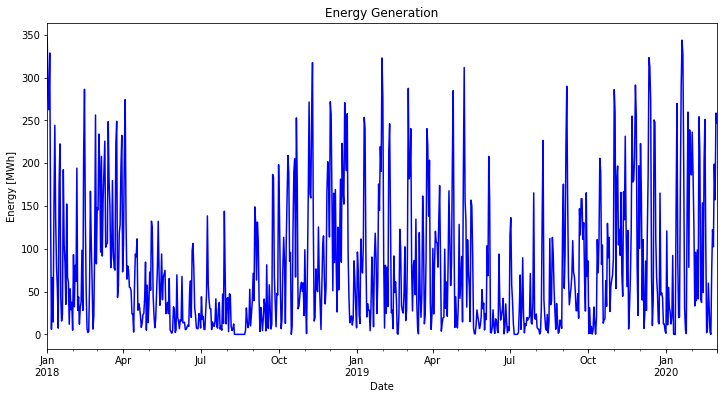

In [8]:
# display plot 
plt.figure(figsize = (12,6))
Energy.plot(title = 'Energy Generation', color = 'blue')
plt.ylabel('Energy [MWh]')
plt.show()

### Data Slicing


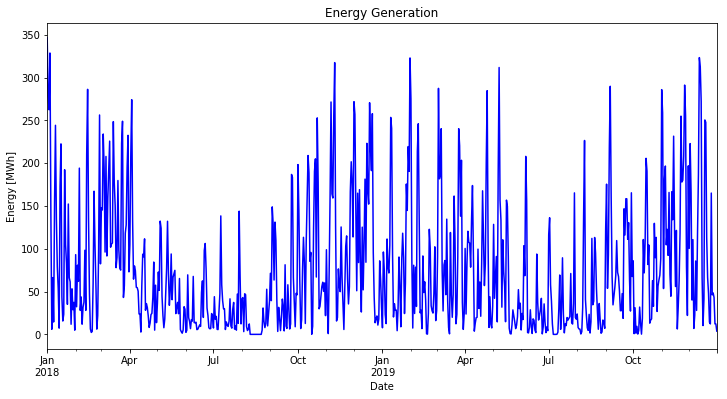

In [9]:
# Slicing up to dec-19
final_2019 = 730
plt.figure(figsize = (12,6))
Energy[0:final_2019].plot(title = 'Energy Generation', color = 'blue')
plt.ylabel('Energy [MWh]')
plt.show()

In [10]:
Energy[0:final_2019].tail()

Date
2019-12-27    48.44
2019-12-28    43.18
2019-12-29    12.30
2019-12-30    12.09
2019-12-31     3.79
Name: Energy(MWh), dtype: float64

## Mean Generation per Month

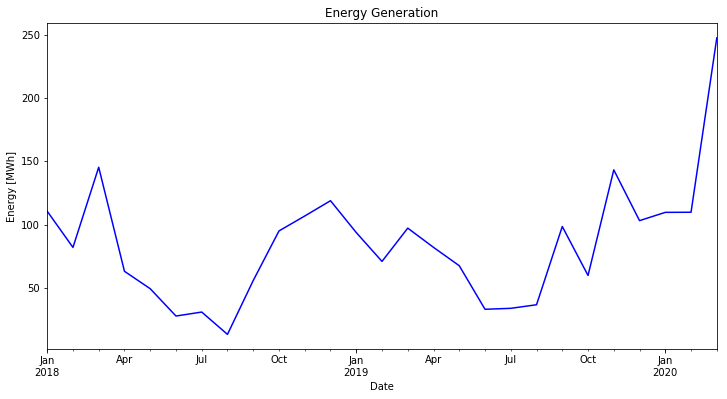

In [11]:
freq = 'M'
# Mean generation per month
media_energy_df = Energy.resample(freq).mean()

# Display plot
plt.figure(figsize = (12,6))
media_energy_df.plot(title = 'Energy Generation', color = 'blue')
plt.ylabel('Energy [MWh]')
plt.show()

## Mean Generation per Quarter 

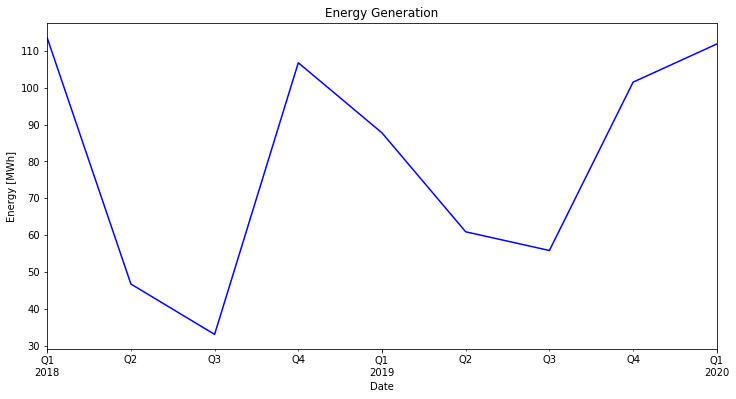

In [12]:
freq = 'Q'
# Calculate energy generation per quarter 
mean_energy_df = Energy.resample(freq).mean()

# Display 
plt.figure(figsize = (12,6))
mean_energy_df.plot(title = 'Energy Generation', color = 'blue')
plt.ylabel('Energy [MWh]')
plt.show()

---
## Create Time Series 

My goal will be to take full years of data, from 2018-2019, and see if I can use it to accurately predict the average energy production for the the last month of each year!

Notice that if you have more data, you can train your model with more years. That way the model is most likely to recognize the patterns in the time series.

Next, let's make one time series for each complete year of data. This is just a design decision, and I am deciding to use full years of data, starting in January of 2018 ; I could have also decided to construct time series starting at the first collected data point, just by changing `t_start` and `t_end` in the function below.

The function `make_time_series` will create pandas `Series` for each of the passed in list of years `['2018', '2019']`.
* All of the time series will start at the same time point `t_start` (or t0). 
    * When preparing data, it's important to use a consistent start point for each time series; DeepAR uses this time-point as a frame of reference, which enables it to learn recurrent patterns e.g. that weekdays behave differently from weekends or that Summer is different than Winter.
    * You can change the start and end indices to define any time series you create.
* We should account for leap years(if the series contains a leep year) in the creation of time series.
* Generally, we create `Series` by getting energy data (from the DataFrame) and date indices.

In [13]:
def make_time_series(energy_df, years, freq='D', start_idx=0, has_leap_year = None, leap_year = None):
    
    '''
    Creates as many time series as therea are complete years. Accounts for leap year when required.
    

    ARG:
    energy_df(dataframe): Dataframe of energy generated by the Sotavendo wind farm
    years(list): list of years to make time series out of. ex. ['2018', '2019']
    freq(string): The frequency of the data recording (D= daily, M = monthly...)
    start_indx(int): The starting index of the first point in the first series - default = 0 
    has_leap_year(binario):Binary that informs whether the list of years has a leap year
    leap_year(int): The Leap year
    
    RETURNS:
    time_series(list): List of series'''
    
    # grava as time series
    time_series = []
    
    if has_leap_year:
        # valor do ano bissexto
        leap = leap_year
    

    # Cria um time series para cada ano da lista years
    for i in range(len(years)):

        year = years[i]
        
        if has_leap_year:
            year == leap
            end_idx = start_idx+366
            
        else:
            end_idx = start_idx+365

        # Cria o inicio e o fim do nosso datetime
        t_start = year + '-01-01' # Primeiro de janeiro e nosso t_start (ou t0)
        t_end = year + '-12-31' # 31 de Dezembro e o t_end

        # Slicing nos dados de energia
        data = energy_df[start_idx:end_idx]

        # Cria time series para cada ano
        index = pd.date_range(start=t_start, end =t_end,  freq=freq)
        time_series.append(pd.Series(data=data, index=index))
        
        start_idx = end_idx
    
    # Retorna lista de time series
    return time_series

In [14]:
energy_df = df['Energy(MWh)']
energy_df.head()

Date
2018-01-01    346.40
2018-01-02    278.51
2018-01-03    262.45
2018-01-04    328.73
2018-01-05    140.07
Name: Energy(MWh), dtype: float64

In [15]:
# Verificando a funcao
# Time series para cada ano
years = ['2018', '2019']

freq ='D' # frequencia diaria

# Cria time series
time_series = make_time_series(energy_df, years, freq=freq)

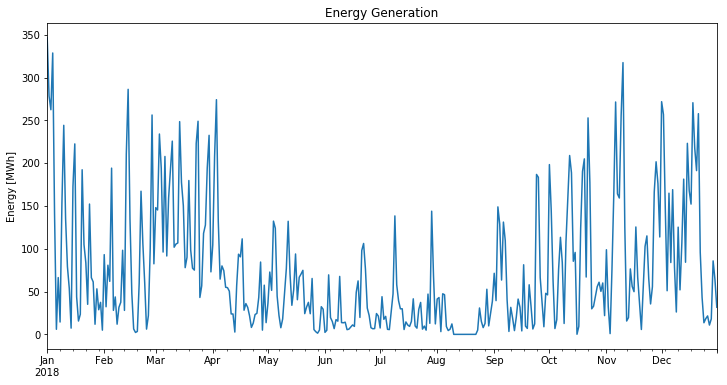

In [16]:
# Display the first time series
time_series_idx = 0

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot(title = 'Energy Generation')
plt.ylabel('Energy [MWh]')
plt.show()

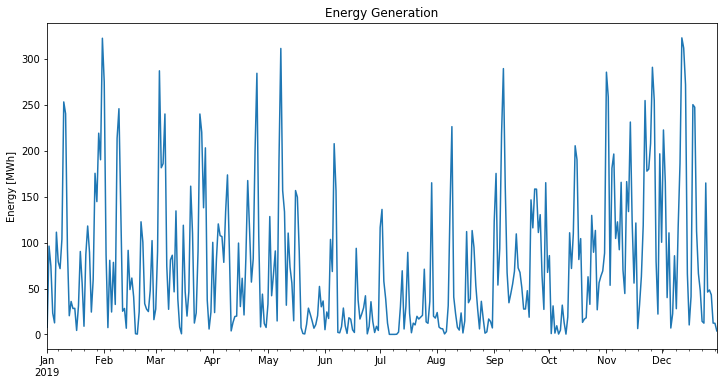

In [17]:
# Display the second time series
time_series_idx = 1

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot(title = 'Energy Generation')
plt.ylabel('Energy [MWh]')
plt.show()

# Spliting the Data


We'll evaluate our model on a test set of data. When dealing with time series forecast it's important to create a train/test splitting examples in time rather than by individual data points as we usually do, for exemplo, when we are workind with machine learning tasks like classification.

In general, we can create training data by taking each of our complete time series and leaving off the last prediction_length data points to create training time series.

I created create_training_series function, which takes in our list of complete time series data and returns a list of truncated, training time series.

In this example, we want to predict about a month's worth of data, and we'll set prediction_length to 30 (days).
To create a training set of data, we'll leave out the last 30 points of each of the time series we just generated, so we'll use only the first part as training data.
The test set contains the complete range of each time series.

In [18]:
# Created truncated,training time series
def create_training_series(complete_time_series, prediction_lenght):
    '''Creates a list of time series data and training time series
    ARG: 
    complete_time_series(list): A list of all complete time series
    prediction_lenght(): The number of points that we want to predict
    
    RETURNS:
    time_series_training(list): A list of training time series'''
    
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        time_series_training.append(ts[: -prediction_lenght])
        
    return time_series_training

In [19]:
prediction_length = 30

time_series_training = create_training_series(time_series, prediction_length)

### Training and Test set

We can see above how these series look like by plotting the train/test series on the same axis. Notice that the test series contains all of our data in a year, and the training series contains all but the last prediction_length points.

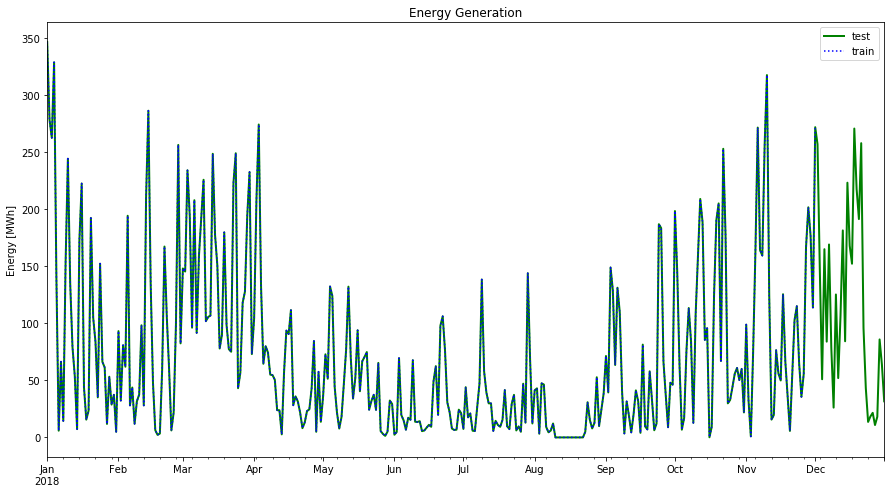

In [20]:
# Display the first time series
time_series_idx = 0

plt.figure(figsize=(15,8))

time_series[time_series_idx].plot(label= 'test',color ='g', lw = 2,title = 'Energy Generation')

time_series_training[time_series_idx].plot(label= 'train',color = 'b', ls = ':')

plt.ylabel('Energy [MWh]')
plt.legend()
plt.show()


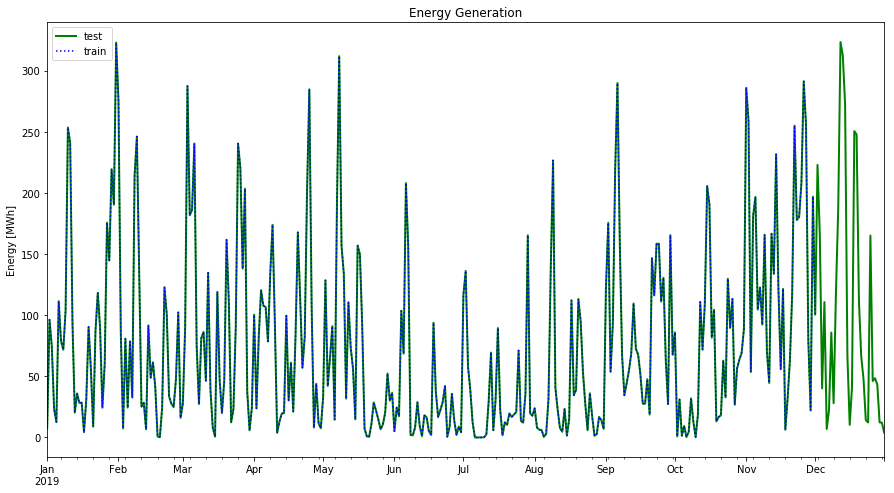

In [21]:
# Display the first time series
time_series_idx = 1

plt.figure(figsize=(15,8))

time_series[time_series_idx].plot(label= 'test',color ='g', lw = 2,title = 'Energy Generation')

time_series_training[time_series_idx].plot(label= 'train',color = 'b', ls = ':')

plt.ylabel('Energy [MWh]')
plt.legend()
plt.show()

### Convert to JSON



According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.

The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:
```
{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 
...
```
In the above example, each time series has one, associated categorical feature and one time series feature.

### Formatting Energy Consumption Data

For our data:
* The starting date, "start," will be the index of the first row in a time series, Jan. 1st of that year.
* The "target" will be all of the energy consumption values that our time series holds.
* We will not use the optional "cat" field.

The following utility function converts `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume.

In [22]:
def series_to_json_obj(ts):
    '''Returns adictionary of values in DeepAr, JSON format
    ARG:
    ts(series): A single time series
    
    RETURNS:
    json_obj(json) : A dictionary of values with "start" and "target" keys'''
    
    json_obj =  {"start": str(ts.index[0]), "target": list(ts) }
    
    return json_obj
    

## Saving data, locally

In [23]:
import json
import os

def write_json_dataset(time_series, filename):
    
    with open(filename, 'wb') as f:
        #for each time series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename +' saved.')

In [24]:
# dave this data to a local directory
data_dir = 'json_energy_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [25]:
# directory to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir,'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)
write_json_dataset(time_series, test_key)

json_energy_data/train.json saved.
json_energy_data/test.json saved.


In [26]:
train_key

'json_energy_data/train.json'

# uploading data to S3

In order to make this data accessible to an estimator, we have to upload it to S3.

### Sagemaker resources

we will start by specifying:

* the sagemeker role session for training a model
* A default S3 bucket where the training,test and model data can be stored, 

In [27]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [28]:
# session, role and bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()


## Upload both training and test json file to S3

Specify unique train and test prefixes that define the location of that in S3

* Upload trainind data to a location in S3, and save that location to `train_path`
* Upload test data to a location in S3, and save that location to `test_path`

In [29]:
# prefix
prefix = 'deepar-energy-generation'

# unique train/test prefixes
train_prefix = '{}/{}'.format(prefix, 'train')
test_prefix = '{}/{}'.format(prefix,'test')

# upload data to S3, and saving locations

train_path = sagemaker_session.upload_data(train_key,
                                         bucket = bucket,
                                         key_prefix = train_prefix)

test_path = sagemaker_session.upload_data(test_key,
                                        bucket = bucket ,
                                        key_prefix = test_prefix)

# Training a DeepAR Estimator

Let's create a base `Estimator` and pass in the specific container (or image) tat holds the model.

Now, we have to configure the container image to be used for the region we are running in.

In [30]:
from sagemaker.amazon.amazon_estimator import get_image_uri


image_name = get_image_uri(boto3.Session().region_name,'forecasting-deepar') # forecasting-deepar is the image we want

## Intantiate an Estimator

Let's now define the estimator that will launch the training job.

> You can take a look at the [estimator source code](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/estimator.py#L595) to view specifics.

In [31]:
from sagemaker.estimator import Estimator

# directory to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket,prefix)


# instanciate a DeepAR estimator
estimator = Estimator(sagemaker_session = sagemaker_session,
                     image_name = image_name,
                     role = role,
                     train_instance_count = 1,
                     train_instance_type = 'ml.c4.xlarge',
                     output_path = s3_output_path)

## Setting Hyperparameters

now we have to define some hyperparameters for our model that define its size and training behavior. We will set value for the epochs, frequency, prediction lenght and context length.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 


### Context Length

It is recommended that we start with a `context_length`=`prediction_length` because the DeepAR model also receives "lagged" inputs from the target time series. This allows the model to capture long-term dependencies. For instance, a daily time series can have yearly seasonality and DeepAR automatically includes a lag of one year. So, the context length can be shorter than a year, and the model will still be able to capture this seasonality.

The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are the previous week, 2 weeks, 3 weeks, 4 weeks, and year. You can read more about this in the [DeepAR "how it works" documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html)

### More Hyperparameters

We can also choose other Hyperparameters to tune the model. For example, we can set a specific number of layers in our RNN model,the likehook function and the training options.

In [32]:
freq='D'
# same as prediction_length
context_length=30 

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [33]:
# set the hyperparameters
estimator.set_hyperparameters(**hyperparameters)

# Training Job

Let's now launch the training job. By doing that, the sagemaker will start an EC2 instance, download the data from S3, start training the model and save the model artifacts.

As we are providing the `test` data channel, the model will also calculate accuracy metrics for the trained model on the test data set we've provided. The DeepAR algorithm does that by predicting the last `prediction_length` points of each time series in the test set and comparing this to the *actual* value of the time series.


In [34]:
%%time
#train and test channels
data_channels = { "train": train_path,
                "test": test_path}

# fit the estimator
estimator.fit(inputs = data_channels)

2020-04-10 18:53:28 Starting - Starting the training job...
2020-04-10 18:53:30 Starting - Launching requested ML instances......
2020-04-10 18:54:32 Starting - Preparing the instances for training......
2020-04-10 18:55:45 Downloading - Downloading input data...
2020-04-10 18:56:18 Training - Training image download completed. Training in progress.Arguments: train
[04/10/2020 18:56:20 INFO 139809354057536] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': 

# Deploy and Create a Predictor


After training the model we can use it to perform predictions by deploying it to a predictor endpoint.

`Note`: Don't forget to delete the endpoint at the end of your predicton.

In [36]:
%time

#create a predictor

predictor = estimator.deploy( initial_instance_count =1,
                            instance_type = 'ml.t2.medium',
                            content_type ='application/json') # specify the it will accept and produce json file

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
---------------!

---
# Predictions

It's important to mention that the `predictor` expects data in a JSON format, with the following keys:


* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Check the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR model.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate quantile estimates for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```


## JSON Prediction Request

The code below accepts a **list** of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [37]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    ''' Takes in a list of input time series and produces a formatted input
    
    ARG:
    input_ts(series): A list of input time series
    num_samples(int): A number of samples to calculate metrics with
    quantiles(list): A list of quantiles to return in the predicted output
    
    RETURNS:
    json_request(json): A jason formated input'''
    
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

# Get a Prediction

Now we can pass the formated input into the predictor endpoint in order to get the model prediction.

In [39]:
input_ts = time_series_training
target_ts = time_series

# get formated input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction =predictor.predict(json_input_ts)



# Decoding Predictions

The predictor retuns a json-formatted prediction and we need to extract the predictions and quantile data that we want for visializing the result. The function below, reads in a json-formatted prediction and produces a list of predictions in each quantile.

In [40]:
# decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Takes in a json prediction and returns a lisf of predictions data
    ARG:
    prediction(json): The json prediction to be decoded
    encoding(string): The encoding type
    
    RETURNS:
    prediction_list(list): A list holding the predictions'''

    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list


In [44]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# we have a list of 30 predictions as expected 
prediction_list[0]

,0.1,0.9,0.5
0,32.383606,293.647247,160.895370
1,43.762283,244.925766,115.556084
2,35.654026,266.679199,125.599777
3,26.999756,227.929535,100.455666
4,4.987648,74.133179,28.879072
5,24.984512,56.196232,39.018120
6,38.327671,82.373009,57.808598
7,34.423431,80.766922,54.411125
8,18.444416,69.278404,45.524914
9,42.084808,146.452271,82.184776


# Results

* Quantile 0.1 and 0.9 represent higher and lowr bounds fot the predicted values.
* quantile 0.5 reprsents the median of all sample predictions.

In [46]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

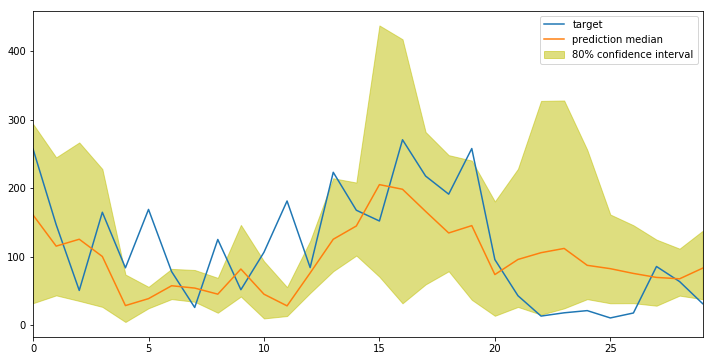

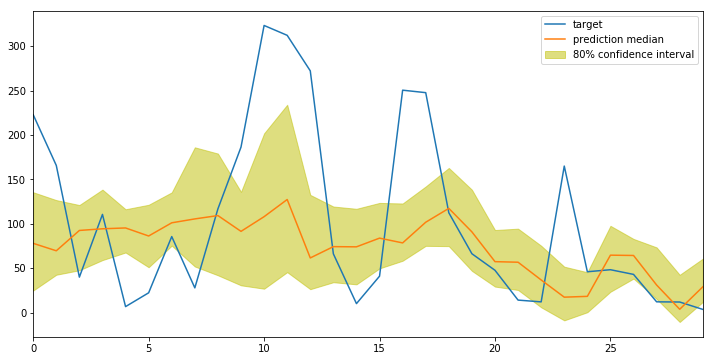

In [47]:
# display predictions
display_quantiles(prediction_list, target_ts)

# Delete endpoint

In [2]:
predictor.delete